# Flash Method Data Reduction Using ODRPACK 
##  Version for an exponential shape heat pulse
 (c) Jozef Gembarovic 2015, 2016

 ODRPACK (Orthogonal Distance Regression  PACKage) Version 2.1 - see [manual](https://docs.scipy.org/doc/external/odrpack_guide.pdf)

 Imports Flash models and other packages

In [118]:
from flashmodels3 import *
import pandas as pd
from ggplot import *

## Read  Experimental Data from a File

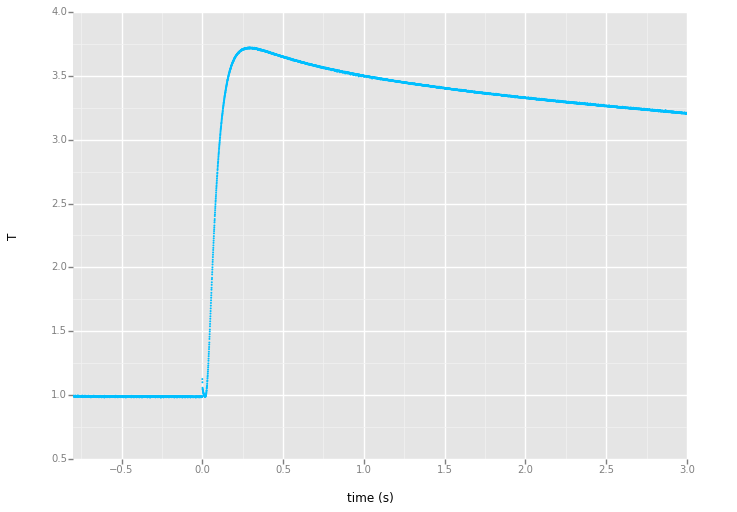

<ggplot: (-9223372036834854028)>

In [119]:
m = np.loadtxt("ss93_200_C.txt", delimiter=" ", skiprows=3)
sfreq=15000 #sampling frequency
starti0=int(0.0*sfreq) #the start time index; the pulse start time is 0.8 s
starti=int(0.8*sfreq) #the start time index; the pulse start time is 0.8 s
endi=int(20*sfreq)+starti #the end tiem index (the end time 20 s)
etime1= m[starti:endi, 1]
etime0=m[starti0:endi, 1]
etime=etime1-0.8
etime0=etime0-0.8
etemperature=m[starti:endi,2]
etemperature0=m[starti0:endi,2]

# deplete the data - take every 10th point
etime0=etime0[::10]
etemperature0=etemperature0[::10]
etime=etime[::10]
etemperature=etemperature[::10]


edata=pd.DataFrame({'etime':etime0,'etemperature':etemperature0})
p=ggplot(edata,aes('etime','etemperature')) + \
    geom_point(size=4, color='deepskyblue')+\
    xlab('time (s)') + ylab('T') +  scale_x_continuous(limits=[-0.8 , 3.0])+\
    theme_gray()
p
#ggplot.save(p,filename = 'SS93_200C0d.eps', width = 6, height = 5)



In [120]:
# a detail figure
edata=pd.DataFrame({'etime':etime0,'etemperature':etemperature0})
p=ggplot(edata,aes('etime','etemperature')) + \
    geom_point(size=4, color='deepskyblue')+\
    xlab('time (s)') + ylab('T') +  scale_x_continuous(limits=[-0.1 , 0.30])+\
    theme_gray()
p
#ggplot.save(p,filename = 'SS93_200C003d.eps', width = 6, height = 5)

<ggplot: (19883766)>

### Sample Dimensions

In [121]:
#Stainless steel sample SS93 dimensions (this is not the best example, but it works)

L = 0.1572 # thickness

# exponential pulse: f(t)=(t/tau**2)exp(-t/tau) 
# tau is the maximum
tau = 0.0005 # 0.50 ms

## Use ODRPACK for Finding Optimal Set of Parameters

In [122]:
# first delete the file 'filename' if it already exist 
# to make room for a new one, generated by the ODRPACK
filename="results1DexpodrSS93200Cd.txt" 
## delete only if file exists ##
if os.path.exists(filename):
    os.remove(filename)
else:
    print("Sorry, I can not remove %s file." % filename)
    
# define analytical function for temperature distribution used by the fitting procedure

def f1Dexp(B, x):
    return B[0]+B[1]*flash1Dexp(x, B[2], L, tau) 

flash = odrpack.Model(f1Dexp) # our model will use 1D model, exponential pulse, no heat losses

# take points from sfreq/jump to 3 seconds after the flash
jump=2 # jump over the first x points after the flash beginning (distorted part)
N=400 #  endpoit index. (N-jump+1) is the number of experimental points to be fitted

time=etime[jump:N]
temperature=etemperature[jump:N]

# use already simulated data. sx and sy are uncertainties for time and temperature points, resp.
mydata = odrpack.RealData(time, temperature, sx=0, sy=1.0) 
# define ODRPACK input parameters - beta0 are initial guess values
myodr = odrpack.ODR(mydata, flash, beta0=[1.0,2.5, 0.01],  
                    iprint=6616, rptfile=filename, ifixb=[1,1,1], job=2 )             
# for the baseline level, Beta[0], Tmax, Beta[1], and the thermal diffusivity, Beta[2]
                                                    
myoutput = myodr.run() # run ODRPACK)
myoutput.pprint() # print a standard simple output

# a more detail report from the ODRPACK is in
# a freshly created text file "results1DexpodrSS93200Cd.txt"  

Beta: [ 0.97808688  2.8116066   0.04542368]
Beta Std Error: [  2.26902273e-03   2.39234757e-03   6.37645971e-05]
Beta Covariance: [[  1.95537579e-02  -1.54300013e-02  -3.42659868e-04]
 [ -1.54300013e-02   2.17370744e-02   5.25500789e-05]
 [ -3.42659868e-04   5.25500789e-05   1.54422927e-05]]
Residual Variance: 0.00026329793970753055
Inverse Condition #: 0.06913224501348986
Reason(s) for Halting:
  Sum of squares convergence


## Reconstruct the Response Curve

In [123]:
B = myoutput.beta # final results of calculated optimal parameters
time = etime[jump:N]

theory1Dexp  = B[0]+B[1]*flash1Dexp(time, B[2], L, tau) 
residuals = temperature - theory1Dexp
print ('Calculated Optimal Values of [baseline level, Tmax, thermal diffusivity] are: \n', B)
print("Literature value for the thermal diffusivity of Stainless Steel (304) at 200 C, is 0.0427 cm^2/s.") 
print ("Relative Difference:", round((B[2]-0.0427)/0.0427*100,3),"%")



Calculated Optimal Values of [baseline level, Tmax, thermal diffusivity] are: 
 [ 0.97808688  2.8116066   0.04542368]
Literature value for the thermal diffusivity of Stainless Steel (304) at 200 C, is 0.0427 cm^2/s.
Relative Difference: 6.379 %


In [124]:

# 95% confidence interval (CI=1.96*sigma)  plus (pCI) and minus (mCI)
sigma=sqrt(sum((residuals)**2)/(N-jump+1))
mCI=theory1Dexp+2*sigma
pCI=theory1Dexp-2*sigma

thdataAll=pd.DataFrame({'etime':etime[jump:N],'time':time,'theory':theory1Dexp,\
                        'etemperature':etemperature[jump:N],'mCI':mCI,'pCI':pCI,'residuals':residuals})
#thdataAll

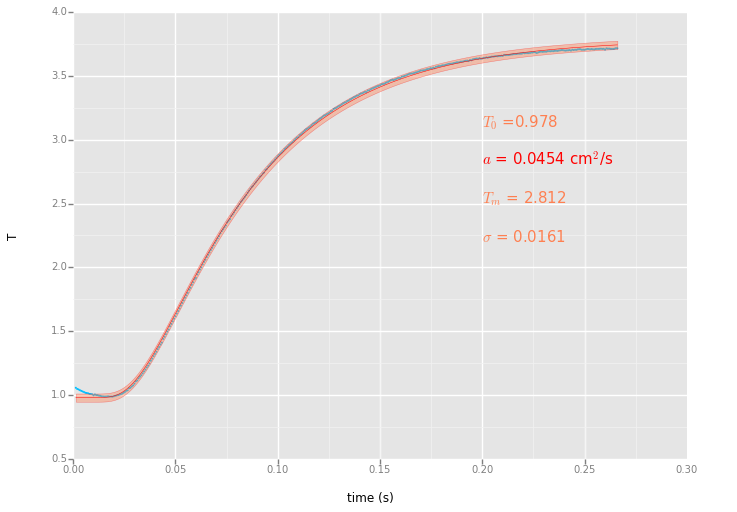

<ggplot: (20646485)>

In [125]:
# define descriptions
      
dataText0=pd.DataFrame.from_items([('x',[0.2]),('y',[3.1]),('text',['$T_0$ =0.978'])])
dataText1=pd.DataFrame.from_items([('x',[0.2]),('y',[2.8]),('text',['$a$ = 0.0454 cm$^2$/s' ])])
dataText2=pd.DataFrame.from_items([('x',[0.2]),('y',[2.5]),('text',['$T_m$ = 2.812'])])
dataText4=pd.DataFrame.from_items([('x',[0.2]),('y',[2.2]),('text',['$\sigma$ = 0.0161'])])

p=ggplot(thdataAll,aes('etime','etemperature')) + \
    geom_point(size=4.0, color='deepskyblue')+\
    geom_line(aes('time','theory',colour='red', size=0.5))+\
    geom_ribbon(aes('time',ymin='mCI',ymax='pCI'), fill="coral", alpha=0.4)+\
    xlab('time (s)') + ylab('T') +  scale_x_continuous(limits=[0.0 , 0.30])+\
    geom_text(aes(x='x', y='y', label='text', size=15, colour='coral'), data=dataText0)+\
    geom_text(aes(x='x', y='y', label='text', size=15, colour='red'), data=dataText1)+\
    geom_text(aes(x='x', y='y', label='text', size=15, colour='coral'), data=dataText2)+\
    geom_text(aes(x='x', y='y', label='text', size=15, colour='coral'), data=dataText4)+\
    theme_gray()

#ggplot.save(p, filename='fig_1.png')
#ggplot.save(p,filename = 'short_ODR_OLS_SS93d.eps', width = 6, height = 5)
#ggsave(filename = 'mojplottest.pdf', width = 6, height = 5, units = "cm")
p

In [126]:
sigma

0.016144917508757916

In [127]:
dataText0=pd.DataFrame.from_items([('x',[1.5]),('y',[1.96*sigma]),('text',['+ 2 $\sigma$'])])
dataText1=pd.DataFrame.from_items([('x',[1.5]),('y',[-1.96*sigma]),('text',['- 2 $\sigma$'])])

pr=ggplot(thdataAll,aes('time','residuals')) + \
       geom_point(size=4.0, color='deepskyblue')+\
         xlab('time (s)') + ylab('residuals') +  scale_x_continuous(limits=[0.0 , 0.30])+\
        geom_hline(y=[2*sigma,-2*sigma], color='tomato')+\
        geom_hline(y=0.0, color='gold')+\
           theme_gray()
pr            

#ggplot.save(pr,filename = 'xxxxxxxxxxxxx.eps', width = 8, height = 7)

<ggplot: (12188925)>

In [128]:
ph = ggplot(thdataAll, aes(x='residuals'))+geom_histogram(alpha=0.4, bins=30, color='deepskyblue')+\
scale_x_continuous()#limits=[-0.012 , 0.012])
ph

<ggplot: (12225414)>

##### The End